# Sprint 13 Project

## Task Statement
Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
The RMSE metric on the test set should not be more than 48.


## Data Preprocessing

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
# load data
df = pd.read_csv('taxi.csv',parse_dates=[0],index_col=[0])

In [3]:
# check general info on dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# sort index to ensure chronological order
df.sort_index(inplace=True)
# check min max dates
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [5]:
# resample data by one hour
df = df.resample('1H').sum()
# check changes
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


/var/folders/bl/tw5qhlsx1yq1d35gh81tcyq80000gn/T/ipykernel_46003/561285987.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


,num_orders
datetime,
2018-04-05 08:00:00,41
2018-04-07 09:00:00,41
2018-08-05 04:00:00,122
2018-05-11 11:00:00,84
2018-05-20 17:00:00,71


## Exploratory Data Analysis

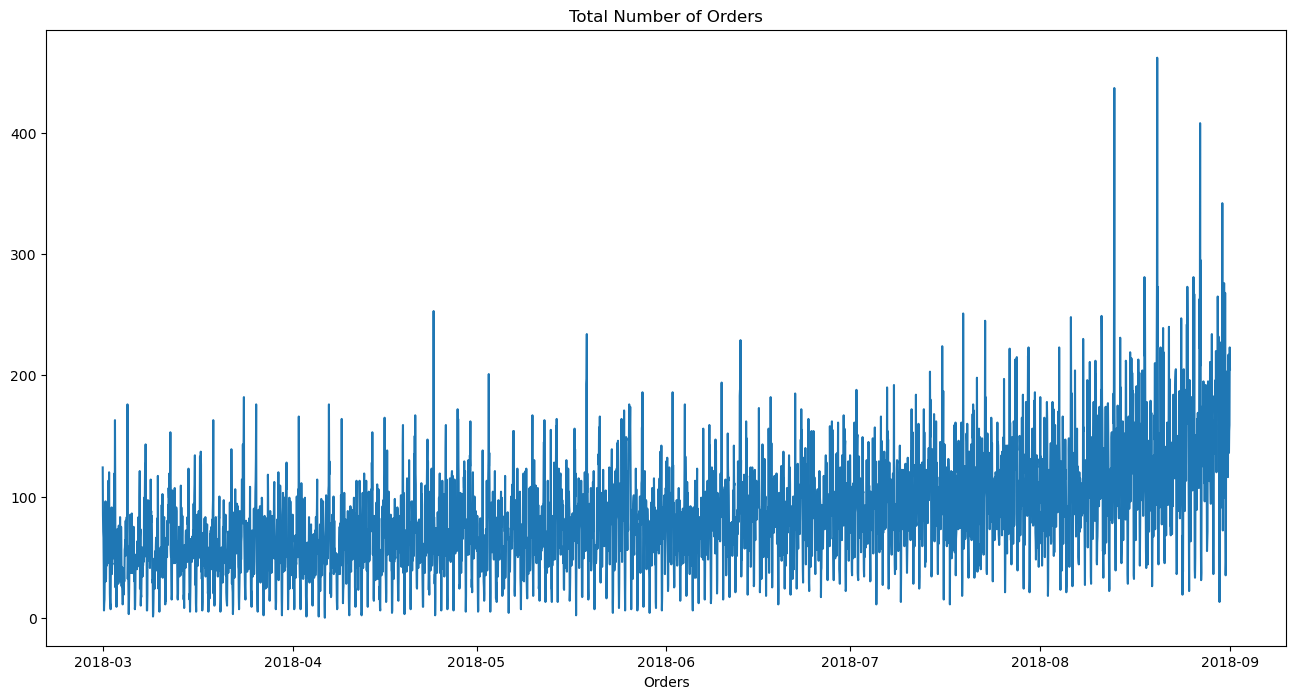

In [6]:
# plot total number of trips
plt.figure(figsize=(16,8))
plt.title('Total Number of Orders')
plt.xlabel('Date')
plt.xlabel('Orders')
plt.plot(df)

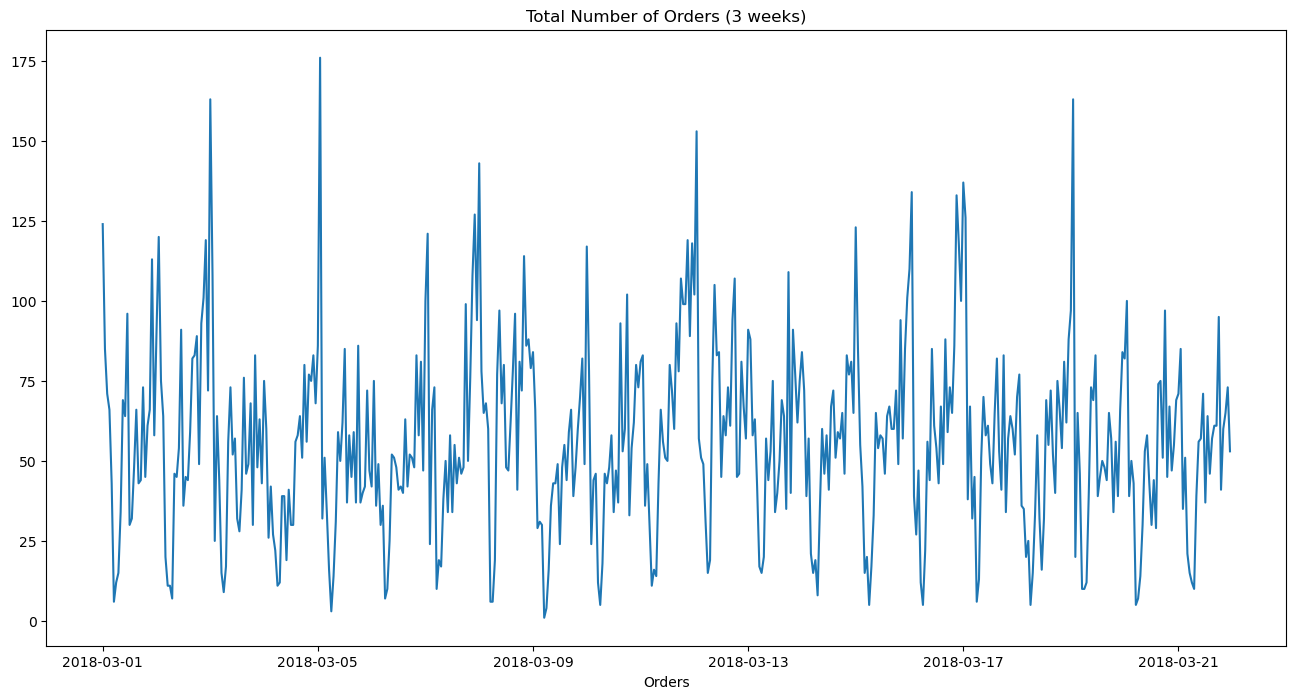

In [7]:
# plot total number of orders in 3 weeks
plt.figure(figsize=(16,8))
plt.title('Total Number of Orders (3 weeks)')
plt.xlabel('Time')
plt.xlabel('Orders')
plt.plot(df.loc['2018-03-01':'2018-03-21'])

There is a pretty clear daily pattern with the number of trips being quite high at the very start of the day (midnight) and then dipping to its lowest number of trips in the early morning hours. There also could be some patterns in the number of trips depending on the day of the week, but you can't easily point that out with the graph above.

In [8]:
# decompose time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df,'additive')
decomposed_2m = seasonal_decompose(df.loc['2018-03':'2018-4'])

Text(0.5, 1.0, 'Trend')

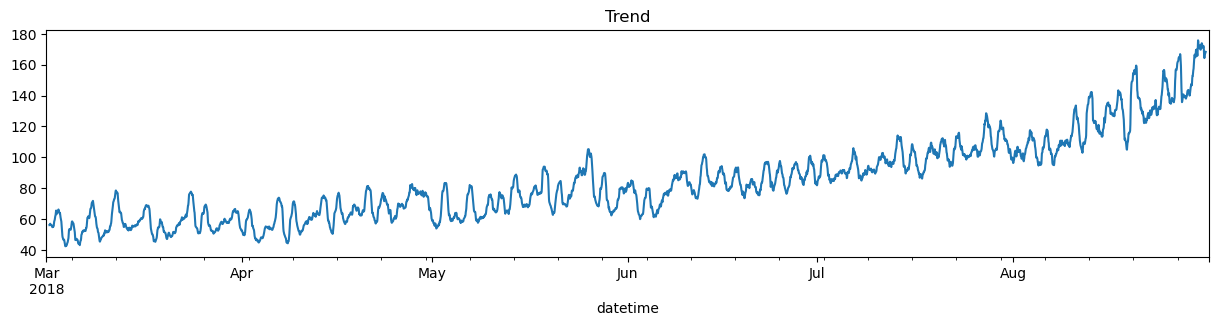

In [9]:
# plot trend
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Trend')

Text(0.5, 1.0, 'Trend')

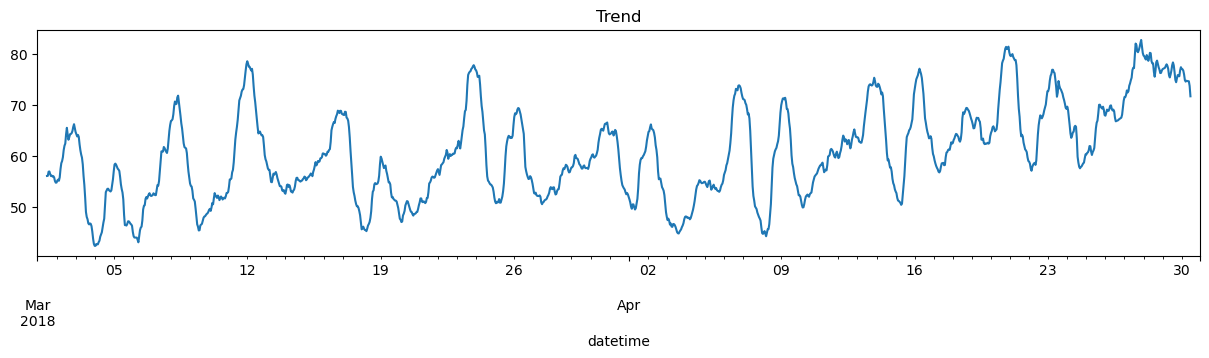

In [10]:
# plot trend for 2 months
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed_2m.trend.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

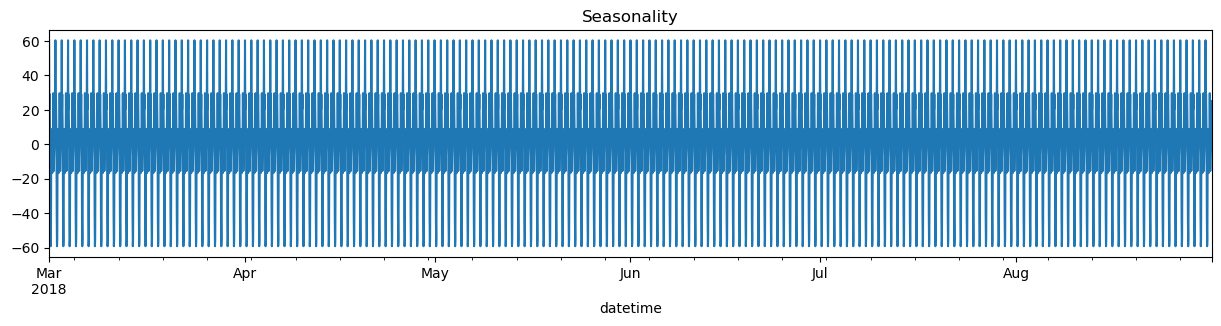

In [11]:
# plot seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

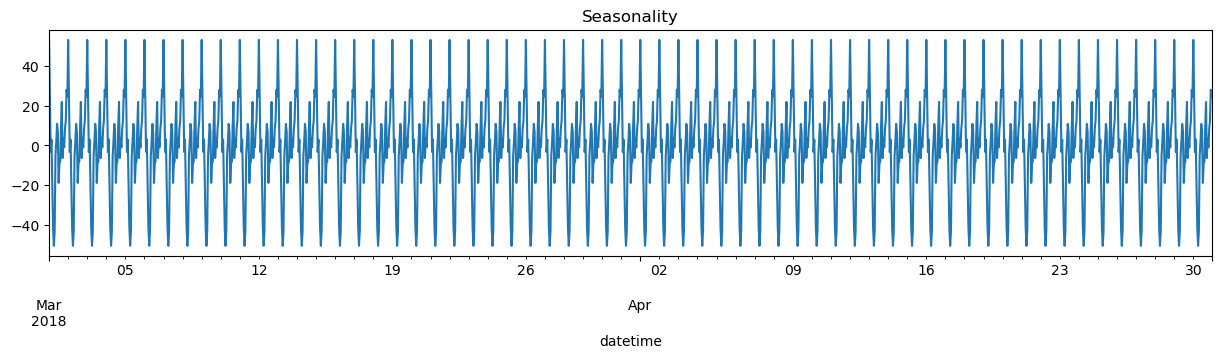

In [12]:
# plot seasonality for 2 months
plt.subplot(312)
decomposed_2m.seasonal.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Seasonality')

Text(0.5, 1.0, 'Residuals')

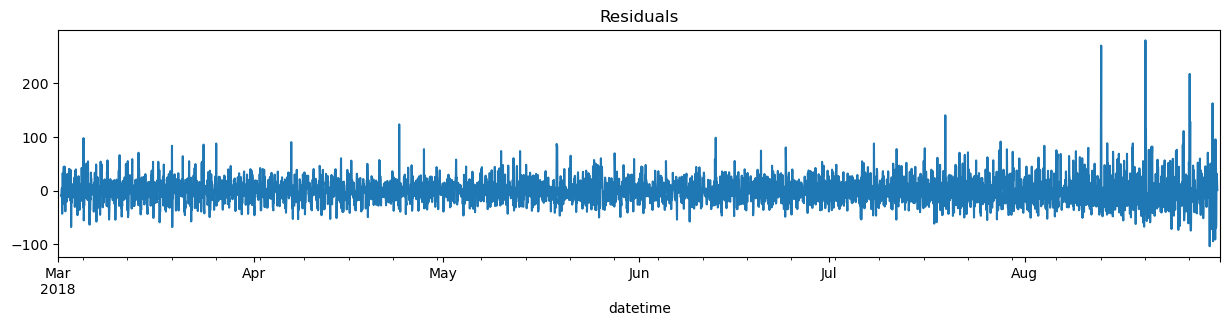

In [13]:
# plot residuals
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Residuals')

Text(0.5, 1.0, 'Residuals')

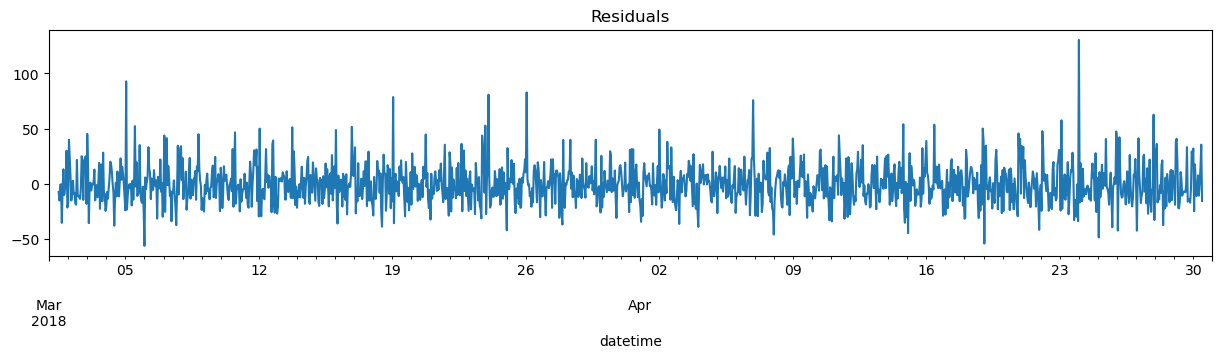

In [14]:
# plot residuals for 2 months
plt.subplot(313)
decomposed_2m.resid.plot(ax=plt.gca(),figsize=(15,10))
plt.title('Residuals')

We can see that there is an overall positive trend in the data, suggesting that the number of trips increase from March to September. We can also see with the seasonality plot that the number of rides is affected by the time of day. 

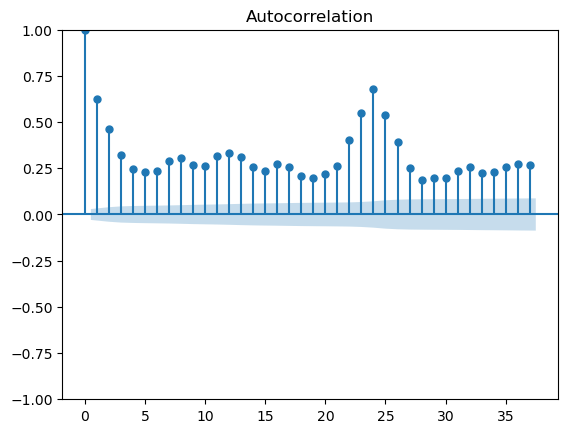

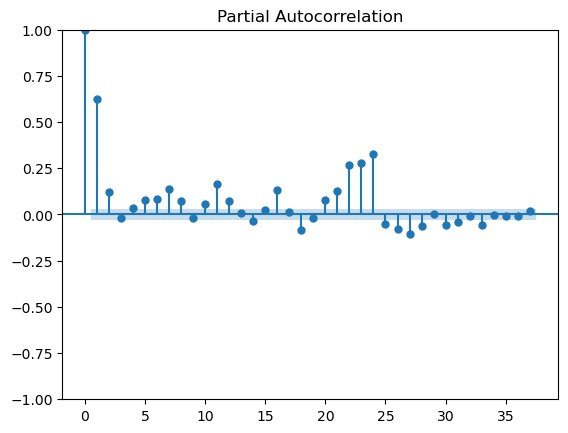

In [15]:
# plot auto correlation & partial auto correlation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df);
plot_pacf(df);

In [16]:
# create rmse function
rmse = lambda X,y: np.sqrt(mean_squared_error(X,y))

In [17]:
# function to plot moving average
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.legend(loc="upper left")
    plt.grid(True)

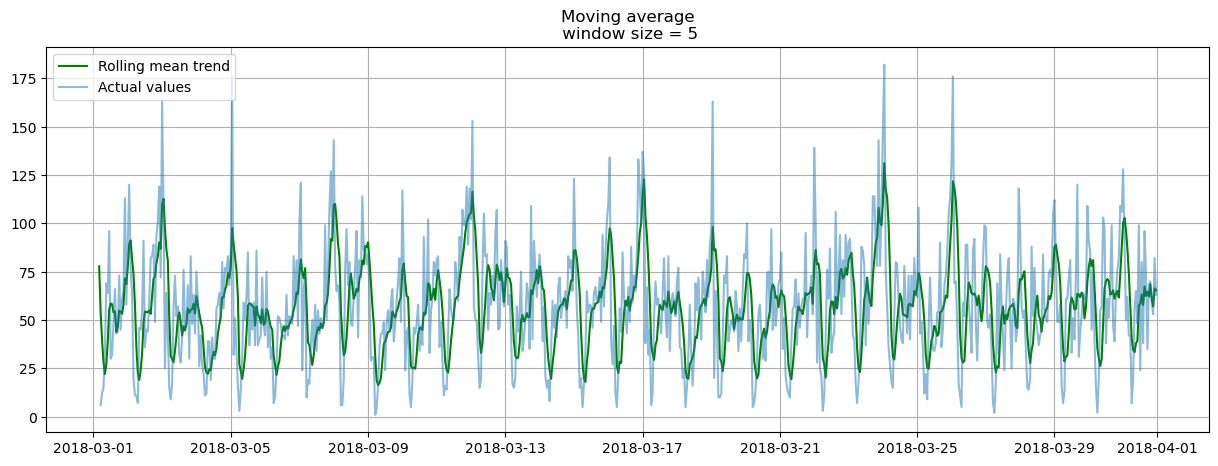

In [18]:
plotMovingAverage(df.loc['2018-03'],5)

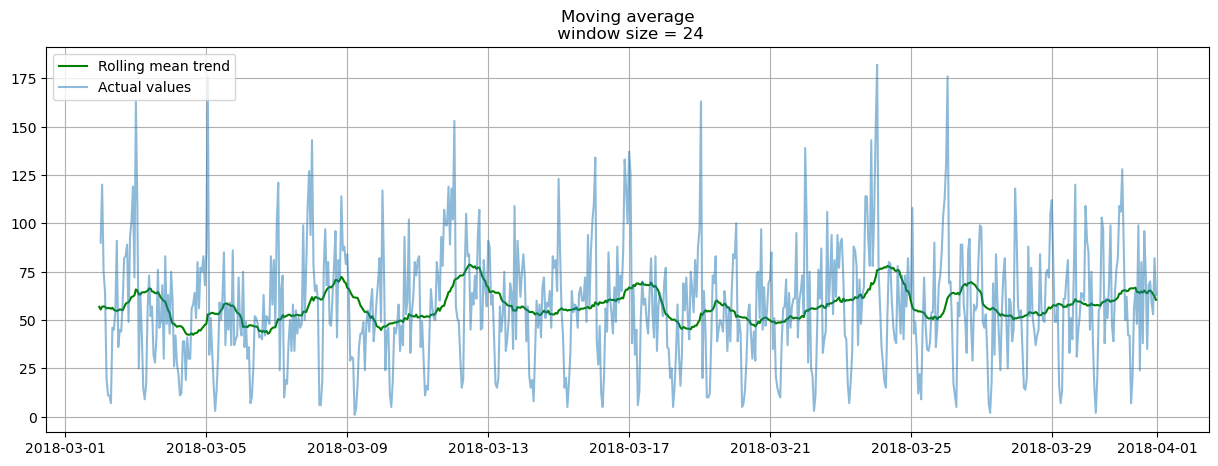

In [19]:
plotMovingAverage(df.loc['2018-03'],24)

A smaller window size for the rolling mean will probably be more useful in regards to feature engineering for the ML model. 

## Feature Preparation

In [20]:
# create date time features
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofwk'] = df.index.dayofweek
df['hour'] = df.index.hour

# create lag features
for lag in range(1,25):
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

# create rolling mean feature
df['rolling_mean_5'] = df['num_orders'].shift().rolling(5).mean()
df['rolling_mean_24'] = df['num_orders'].shift().rolling(24).mean()

In [21]:
# check changes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4416 non-null   int64  
 1   month            4416 non-null   int32  
 2   day              4416 non-null   int32  
 3   dayofwk          4416 non-null   int32  
 4   hour             4416 non-null   int32  
 5   lag_1            4415 non-null   float64
 6   lag_2            4414 non-null   float64
 7   lag_3            4413 non-null   float64
 8   lag_4            4412 non-null   float64
 9   lag_5            4411 non-null   float64
 10  lag_6            4410 non-null   float64
 11  lag_7            4409 non-null   float64
 12  lag_8            4408 non-null   float64
 13  lag_9            4407 non-null   float64
 14  lag_10           4406 non-null   float64
 15  lag_11           4405 non-null   float64
 16  lag_12          

In [22]:
df.sample(5)

,num_orders,month,day,dayofwk,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_5,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-22 23:00:00,109,6,22,4,23,147.0,99.0,110.0,82.0,69.0,...,24.0,38.0,122.0,74.0,102.0,95.0,185.0,73.0,101.4,90.166667
2018-06-29 01:00:00,87,6,29,4,1,161.0,107.0,73.0,136.0,98.0,...,66.0,31.0,42.0,56.0,108.0,109.0,155.0,84.0,115.0,86.750000
2018-03-27 09:00:00,32,3,27,1,9,69.0,18.0,2.0,7.0,34.0,...,92.0,86.0,33.0,50.0,58.0,89.0,89.0,52.0,26.0,56.291667
2018-04-07 19:00:00,80,4,7,5,19,42.0,36.0,100.0,69.0,47.0,...,67.0,67.0,129.0,118.0,176.0,109.0,105.0,63.0,58.8,68.000000
2018-06-03 12:00:00,87,6,3,6,12,44.0,53.0,57.0,52.0,24.0,...,47.0,43.0,48.0,97.0,66.0,69.0,53.0,52.0,46.0,59.666667


In [23]:
# drop rows with missing values
df.dropna(axis='rows',inplace=True)
# check changes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4392 non-null   int64  
 1   month            4392 non-null   int32  
 2   day              4392 non-null   int32  
 3   dayofwk          4392 non-null   int32  
 4   hour             4392 non-null   int32  
 5   lag_1            4392 non-null   float64
 6   lag_2            4392 non-null   float64
 7   lag_3            4392 non-null   float64
 8   lag_4            4392 non-null   float64
 9   lag_5            4392 non-null   float64
 10  lag_6            4392 non-null   float64
 11  lag_7            4392 non-null   float64
 12  lag_8            4392 non-null   float64
 13  lag_9            4392 non-null   float64
 14  lag_10           4392 non-null   float64
 15  lag_11           4392 non-null   float64
 16  lag_12          

In [24]:
# split data in train, valid & test sets
from sklearn.model_selection import train_test_split
train_valid,test = train_test_split(df,shuffle=False,test_size=0.10)
train,valid = train_test_split(train_valid,shuffle=False,test_size=0.1)
train.index.min(), train.index.max(), valid.index.min(),valid.index.max(), test.index.min(),test.index.max()


(Timestamp('2018-03-02 00:00:00'),
 Timestamp('2018-07-28 03:00:00'),
 Timestamp('2018-07-28 04:00:00'),
 Timestamp('2018-08-13 15:00:00'),
 Timestamp('2018-08-13 16:00:00'),
 Timestamp('2018-08-31 23:00:00'))

In [25]:
# define features (X) and target (y)
X_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']
X_valid = valid.drop('num_orders',axis=1)
y_valid = valid['num_orders']
X_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

## Model Creation & Tuning

### Linear Regression for Sanity Check

In [26]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
predicted_valid = lr.predict(X_valid)
print('RMSE:', rmse(y_valid,predicted_valid))

RMSE: 34.19955551311368


### Decision Tree Regressor

In [27]:
from sklearn.tree import DecisionTreeRegressor
for depth in range(1,11):
    dt = DecisionTreeRegressor(random_state=12345,max_depth=depth)
    dt.fit(X_train,y_train)
    predicted_valid = dt.predict(X_valid)
    print('Decision Tree Regressor depth:', depth)
    print('RMSE:', rmse(y_valid,predicted_valid))


Decision Tree Regressor depth: 1
RMSE: 50.508583536136584
Decision Tree Regressor depth: 2
RMSE: 45.316626009089504
Decision Tree Regressor depth: 3
RMSE: 43.4625814817642
Decision Tree Regressor depth: 4
RMSE: 41.159593421624145
Decision Tree Regressor depth: 5
RMSE: 38.351613273919206
Decision Tree Regressor depth: 6
RMSE: 36.50965226879685
Decision Tree Regressor depth: 7
RMSE: 38.20467017374788
Decision Tree Regressor depth: 8
RMSE: 37.72437066865927
Decision Tree Regressor depth: 9
RMSE: 38.40640534599941
Decision Tree Regressor depth: 10
RMSE: 40.24033456690878


### Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor
for est in range(10,51,10):
    rf = RandomForestRegressor(random_state=12345,max_depth=6,n_estimators=est)
    rf.fit(X_train,y_train)
    predicted_valid = rf.predict(X_valid)
    print('Random Forest Regressor n-est:', est)
    print('RMSE:', rmse(y_valid,predicted_valid))

Random Forest Regressor n-est: 10
RMSE: 36.195657920172984
Random Forest Regressor n-est: 20
RMSE: 35.4570615787387
Random Forest Regressor n-est: 30
RMSE: 35.4835078202534
Random Forest Regressor n-est: 40
RMSE: 35.27138931627347
Random Forest Regressor n-est: 50
RMSE: 35.061975989195645


In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
df_cv = TimeSeriesSplit(n_splits = 5)
params = {
    'n_estimators':[10,50,100]
    }
gs = GridSearchCV(estimator=rf,param_grid=params,cv=df_cv)
gs.fit(train_valid.iloc[:,1:],train_valid.iloc[:,0])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(max_depth=6, n_estimators=50,
                                             random_state=12345),
             param_grid={'n_estimators': [10, 50, 100]})

In [30]:
gs.best_params_

{'n_estimators': 100}

In [31]:
predicted_valid_gs = gs.predict(X_valid)
print('GridSearchCV RF RMSE:', rmse(y_valid,predicted_valid_gs))

GridSearchCV RF RMSE: 27.73851242814949


### LightGBM Regressor

In [32]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train,y_train,eval_set=(X_valid,y_valid),eval_metric='rmse')
predicted_lgb_valid = rf.predict(X_valid)
print('RMSE:', rmse(y_valid,predicted_lgb_valid))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4818
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 30
[LightGBM] [Info] Start training from score 74.948538
RMSE: 35.061975989195645


The LinearRegression model performed fairly well but I was able to get an even better quality model with the random forest regressor and using gridsearch and cross validation to find the optimal hyperparameters. I will do a final evaluation on both models using the test set

## Model Evaluation

In [33]:
predited_test_gs = gs.predict(X_test)
print('GridSearchCV RF RMSE:', rmse(y_test,predited_test_gs))

GridSearchCV RF RMSE: 46.817348098744915


## Conclusion
Through the use of resampling, I changed the time interval of the series to fit the requested mode. Using statistical decomposition I was able to recognize trends and seasonality in the data. I utilized autocorrelation, partial correlation and rolling mean to create lag and rolling mean features to improve the training data for the time series modeling. I then created multiple machine learning models, of which the Random Forest Regressor with hyperparameter tuning using GridSearchCV was the best quality model that had a RMSE value of 46.8 when predicting the test dataset.
